In [57]:
# Import internal libraries
import json

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [58]:
# Analyze reliability, bandwidth, energy
data = []
refdir = "../lfsr"
for bpc in range(1, 3):
    refvec = np.loadtxt(f"{refdir}/lfsr_{bpc}bpc_data.txt", delimiter=',', dtype=np.int8)
    for alias in ["best_manual", "ispp8", "ispp31", "best_pba"]:
        for att in [1, 2, 4, 8] + list(range(16, 256, 32)):
            # Real max attempts
            att = (att & 31) << (att >> 5)

            # Load and compute data
            try:
                diag = json.load(open(f"data/diag/diag_{bpc}bpc_{alias}_{att}.json"))
                dt = np.loadtxt(f"data/dt/dt_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivdd_and_dac = np.loadtxt(f"data/power/vdd_and_dac_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivsa = np.loadtxt(f"data/power/vsa_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivddio = np.loadtxt(f"data/power/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
                # ivddio_dac = np.loadtxt(f"data/power/vddio_power_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                continue
            power_tot = 0 #ivdd_and_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
            dt2 = diag["cycles"] * 1e-8
            energy_tot = power_tot * dt2
            bw = 2**16 * 48 * bpc / dt2 # bits per second
            energy_per_bit = energy_tot / 2**16 / 48 / bpc
            edp = energy_per_bit / bw

            # Load data into confmat
            try:
                confmat = np.loadtxt(f"data/confmat/confmat_{bpc}bpc_{alias}_{att}.csv", delimiter=',')
            except OSError:
                try:
                    postread = np.loadtxt(f"data/postread/postread_{bpc}bpc_{alias}_{att}.csv", delimiter=',', dtype=np.int8)
                    confmat = np.zeros(shape=(2**bpc, 2**bpc))
                    for i in range(65535):
                        for j in range(48):
                            if j in [7, 16, 19, 23, 24, 29, 38, 39, 43]: #[16, 19,24,29,38,43]:
                                continue
                            confmat[refvec[i][j]][postread[i][j]] += 1
                    confmat = confmat.astype(int)
                    np.savetxt(f"data/confmat/confmat_{bpc}bpc_{alias}_{att}.csv", confmat, fmt='%s', delimiter=',')
                    print(confmat)
                except OSError:
                    continue

            # Symbol error magnitudes
            mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
            rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

            # Function to get Gray code string
            getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

            # Function to get Gray code error rate for each possible symbol confusion
            grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

            # BER and CER
            ber = (grayerr * confmat).sum() / confmat.sum()
            cer = 1 - confmat.trace() / confmat.sum()
            
            # Compose dataframe
            d = {"alias": alias, "att": att, "bpc": bpc, "dt": dt, "dt2": dt2, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse}
            d.update(diag)
            data.append(d)
data = pd.DataFrame(data)
data

[[401841  48390  29153 159497]
 [243472 207122  28627 159278]
 [160864 161139 157577 159832]
 [     0    789 363307 274977]]
[[462344  17861   6811 151865]
 [275244 203538   7884 151833]
 [162481 164282 165015 147634]
 [     0     95 268983 369995]]
[[537631   9188  13048  79014]
 [335818 211003  13695  77983]
 [206421 189076 175968  67947]
 [     0      4 118898 520171]]
[[609191   5988   2838  20864]
 [146099 388529  11496  92375]
 [ 64851 258621 233779  82161]
 [   250    277   6096 632450]]
[[607719   9898   3199  18065]
 [157175 390089  14306  76929]
 [ 34018  96048 487962  21384]
 [    12     18     44 638999]]
[[616818   8899   2635  10529]
 [164865 462417   4538   6679]
 [ 31945  73501 527316   6650]
 [     0      0     21 639052]]
[[620216   7631   2267   8767]
 [105719 527824   2236   2720]
 [  8854  32411 596023   2124]
 [     0      1     18 639054]]
[[621880   6669   2064   8268]
 [ 75361 560759   1220   1159]
 [  2198   8071 628331    812]
 [     0      0     18 639055]]


,alias,att,bpc,dt,dt2,power_tot,energy_per_bit,edp,bw,cer,...,rmse,successes,failures,reads,sets,resets,cycles,read_bits,set_bits,reset_bits
0,ispp31,1,1,0.055351972579956055,0.055028,0,0.0,0.0,5.716552e+07,1.293926e-01,...,0.359712,65536,131062,327677,65533,65529,5502842,3833591,641658,639497
1,ispp31,2,1,0.0896904468536377,0.089484,0,0.0,0.0,3.515400e+07,7.111095e-03,...,0.084327,65536,111317,458746,111309,131069,8948420,5472483,797665,1173706
2,ispp31,4,1,0.13231825828552246,0.132096,0,0.0,0.0,2.381402e+07,1.721531e-05,...,0.004149,65536,4528,612442,120989,168274,13209564,8270763,818039,1162419
3,ispp31,8,1,0.13108038902282715,0.130836,0,0.0,0.0,2.404322e+07,2.347542e-06,...,0.001532,65536,7,613109,120400,164986,13083636,8355938,816106,1149584
4,ispp31,16,1,0.1305832862854004,0.130306,0,0.0,0.0,2.414103e+07,7.825139e-07,...,0.000885,65536,2,612073,119890,164453,13030629,8349118,813931,1144817
5,ispp31,32,1,0.13037323951721191,0.130172,0,0.0,0.0,2.416593e+07,5.086341e-06,...,0.002255,65536,1,611821,119991,164081,13017202,8346752,813197,1142890
6,ispp31,64,1,0.13014578819274902,0.129911,0,0.0,0.0,2.421440e+07,1.173771e-06,...,0.001083,65536,1,611132,119772,163622,12991148,8343929,812457,1140987
7,ispp31,128,1,0.13100671768188477,0.130750,0,0.0,0.0,2.405919e+07,4.695084e-06,...,0.002167,65536,1,611409,119728,163959,13074954,8343588,812732,1140660
8,ispp31,256,1,0.12992405891418457,0.129786,0,0.0,0.0,2.423786e+07,7.825139e-07,...,0.000885,65536,0,610908,119899,163262,12978571,8341680,812784,1138103
9,ispp31,512,1,0.13090753555297852,0.130667,0,0.0,0.0,2.407439e+07,5.086341e-06,...,0.002255,65536,0,611124,119913,163474,13066698,8342177,813150,1138635


/tmp/ipykernel_983061/121660161.py:14: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axs[2].set_yscale("log")
/tmp/ipykernel_983061/121660161.py:32: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


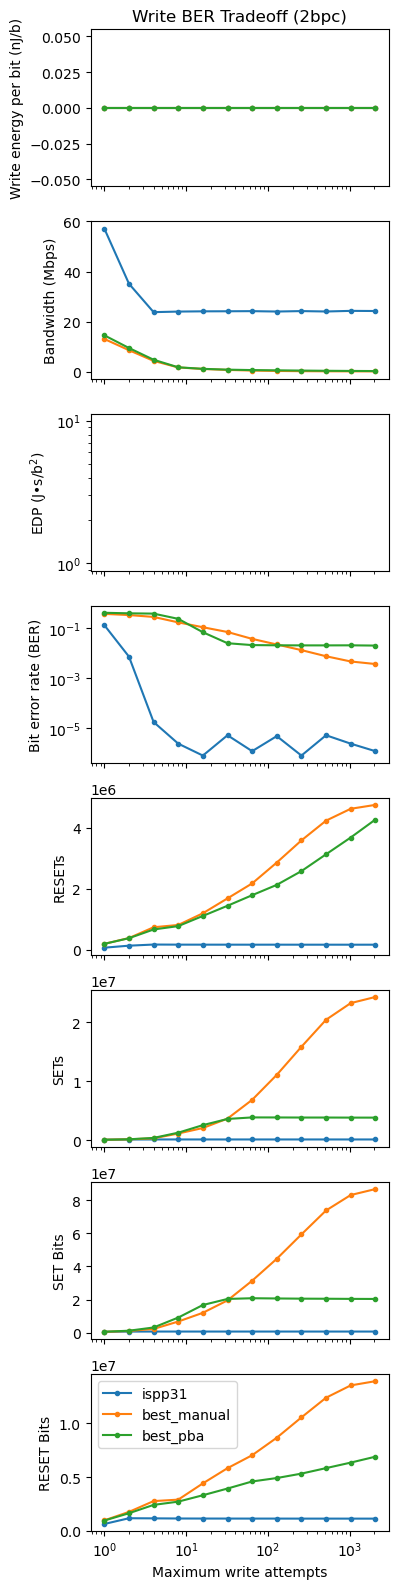

In [59]:
# Plot write BER tradeoff vs. attempts
fig, axs = plt.subplots(8, 1, figsize=(4,16), sharex=True)
for (bpc, alias), d in data.groupby(["bpc", "alias"]):
    plt.xlabel("Maximum write attempts")
    plt.xscale("log")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9, ".-", label=alias)
    # axs[0].set_yscale("log")
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6, ".-", label=alias)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"], ".-", label=alias)
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"], ".-", label=alias)
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    axs[4].plot(d["att"], d["resets"], ".-", label=alias)
    # axs[4].set_yscale("log")
    axs[4].set_ylabel("RESETs")
    axs[5].plot(d["att"], d["sets"], ".-", label=alias)
    # axs[5].set_yscale("log")
    axs[5].set_ylabel("SETs")
    axs[6].plot(d["att"], d["set_bits"], ".-", label=alias)
    # axs[6].set_yscale("log")
    axs[6].set_ylabel("SET Bits")
    axs[7].plot(d["att"], d["reset_bits"], ".-", label=alias)
    # axs[7].set_yscale("log")
    axs[7].set_ylabel("RESET Bits")
plt.legend()
plt.tight_layout()
# plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
plt.show()